In [1]:
import os
import zipfile

#Base de datos
from google.colab import files
files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d dansbecker/cityscapes-image-pairs
#!kaggle datasets download -d whats2000/breast-cancer-semantic-segmentation-bcss

Dataset URL: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs
License(s): other
 94% 190M/202M [00:01<00:00, 195MB/s]
100% 202M/202M [00:01<00:00, 163MB/s]


In [3]:
local_zip = '/content/cityscapes-image-pairs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [4]:
#import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#base_dir = "/kaggle/input/cityscapes-image-pairs/cityscapes_data"

#train_dir = f"{base_dir}/train"
#val_dir = f"{base_dir}/val"

training_images  = glob("/content/cityscapes_data/train/*")
validation_images  = glob("/content/cityscapes_data/val/*")

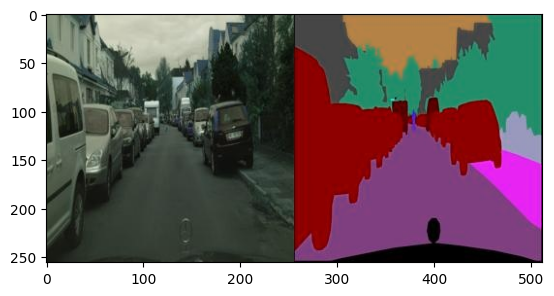

In [5]:
input_image_path = training_images[0]
train_image = cv2.imread(input_image_path)
plt.imshow(train_image)

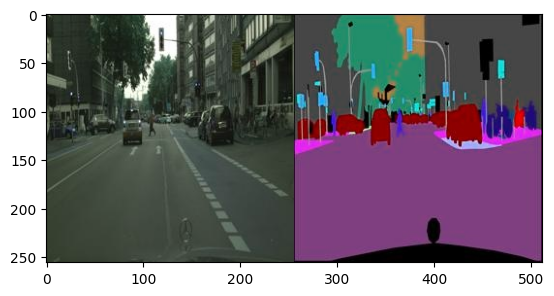

In [6]:
input_image_path = validation_images[0]
val_image = cv2.imread(input_image_path)
plt.imshow(val_image)

In [7]:
print(len(training_images))
print(len(validation_images))

2975
500


In [8]:
image, mask = train_image[:,:256,:], train_image[:,256:,:]

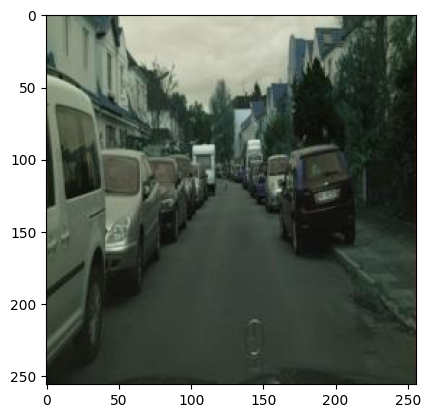

In [9]:
plt.imshow(image)

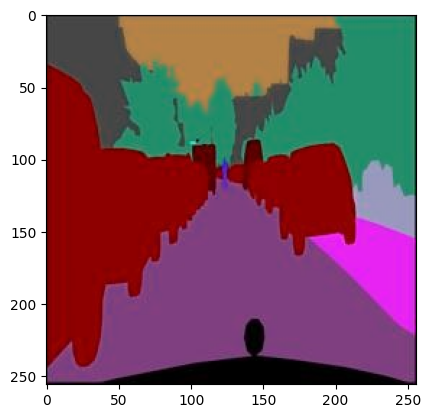

In [10]:
plt.imshow(mask)

In [11]:
#import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage, Resize, ToTensor
# import torch.multiprocessing as mp

In [12]:
# mp.set_start_method('spawn', force=True)

class CityscapesDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.image_paths = glob(os.path.join(self.data_dir, split, '*.jpg'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        train_image = cv2.imread(img_path)

        # Separate the concatenated image into the main image and its corresponding label (mask)
        image = train_image[:, :256, :]
        mask = train_image[:, 256:, :]

        # Apply transformations separately to image and mask
        if self.transform:
            image = self.transform['image'](image)
            mask = self.transform['mask'](mask)

        return image, mask, img_path

In [13]:
base_dir = '/content/cityscapes_data'

# Define separate transformation pipelines for image and mask
image_transform = transforms.Compose([
            ToPILImage(),
            Resize((256, 256)),
            ToTensor(),
        ])
mask_transform = transforms.Compose([
            ToPILImage(),
            Resize((256, 256)),
            ToTensor(),
        ])

data_transform = {'image': image_transform, 'mask': mask_transform}

In [14]:
import os

In [15]:
train_dataset = CityscapesDataset(base_dir, split='train', transform=data_transform)
val_dataset = CityscapesDataset(base_dir, split='val', transform=data_transform)

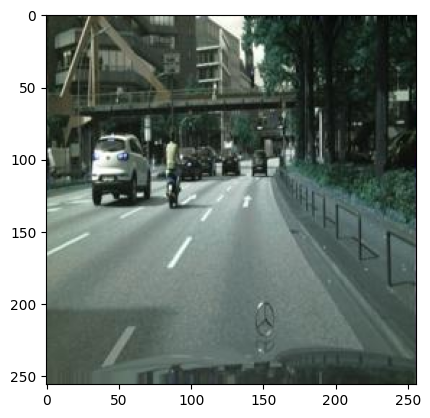

In [16]:
# Example of accessing data
image, mask, image_path = train_dataset[3]
plt.imshow((image.permute(1, 2, 0).numpy()*255).astype(np.uint8))

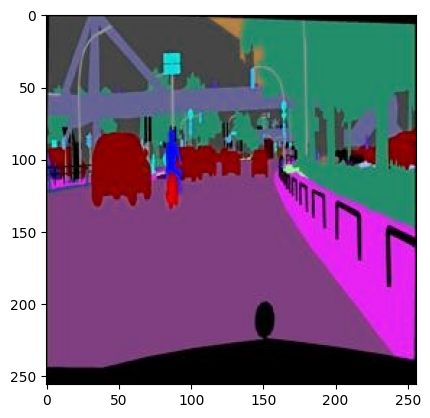

In [17]:
plt.imshow((mask.permute(1, 2, 0).numpy()*255).astype(np.uint8), cmap='gray')
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image

# **Attention Unet**

**Convolution Block**

Conv -> BatchNorm -> ReLU  
Conv -> BatchNorm -> ReLU  

In [19]:
class ConvBlock(nn.Module):
  def __init__(self, ch_in, ch_out):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1,padding=1, bias=True),
                              nn.BatchNorm2d(ch_out),
                              nn.ReLU(inplace=True),
                              nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1,padding=1, bias=True),
                              nn.BatchNorm2d(ch_out),
                              nn.ReLU(inplace=True),
                              )

  def forward(self, x):
    x = self.conv(x)
    return x

**Upsampling Block**

In [20]:
# Upsample -> Conv -> BatchNorm -> ReLU

class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,kernel_size=3,stride=1,padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
                                )

    def forward(self, x):
        x = x = self.up(x)
        return x

**Attention Block**

In [21]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()

        self.w_g = nn.Sequential(nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias="True"),
                                nn.BatchNorm2d(f_int)
                                )
        self.w_x = nn.Sequential(nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias="True"),
                                nn.BatchNorm2d(f_int)
                                )
        self.psi = nn.Sequential(nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias="True"),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
                                )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return psi*x

**Attention Unet**

In [22]:
class Attention_UNet(nn.Module):
    def __init__(self, n_classes=30, in_channel=3, out_channel=3):
        super().__init__()
        ###  Encoder ##
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)

        ### Decoder ###
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)

        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)

        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)

        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)

        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)

        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)

        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)

        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)

        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)

        # decoder + concat
        d5 = self.up5(x5)
        before_att5 = x4.clone()  # Feature map antes del Attention Block
        x4 = self.att5(g=d5, x=x4)
        after_att5 = x4.clone()   # Feature map después del Attention Block
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)

        d4 = self.up4(d5)
        before_att4 = x3.clone()
        x3 = self.att4(g=d4, x=x3)
        after_att4 = x3.clone()
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)

        d3 = self.up3(d4)
        before_att3 = x2.clone()
        x2 = self.att3(g=d3, x=x2)
        after_att3 = x2.clone()
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)

        d2 = self.up2(d3)
        before_att2 = x1.clone()
        x1 = self.att2(g=d2, x=x1)
        after_att2 = x1.clone()
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)

        d1 = self.conv_1x1(d2)

        return d1
        #return d1, before_att5, after_att5, before_att4, after_att4, before_att3, after_att3, before_att2, after_att2

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
device

device(type='cpu')

In [25]:
attention_unet = Attention_UNet(n_classes=1).to(device)

In [26]:
# Parameters
batch_size = 8
num_workers = 1

# DataLoader for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [27]:
#Quick test over small subset of data

from torch.utils.data import Subset
import numpy as np

# Load full dataset
train_dataset_full = train_dataset
val_dataset_full = val_dataset

# Define subset size
subset_size = 100  # Number of samples for quick test

# Generate random indices for the subset
train_indices = np.random.choice(len(train_dataset_full), subset_size, replace=False)
val_indices = np.random.choice(len(val_dataset_full), subset_size, replace=False)

# Create subset
train_subset = Subset(train_dataset_full, train_indices)
val_subset = Subset(val_dataset_full, val_indices)

# Create DataLoader for the subset
train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader_subset = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(train_dataset_full), len(val_dataset_full)

train_loader = train_loader_subset
val_loader = val_loader_subset

In [28]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for images, masks, _ in dataloaders[phase]:
                images = images.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}')

    return model

In [29]:
model = Attention_UNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [31]:
dataloaders = {
    'train': train_loader,
    'val': val_loader,
}

#50 epocas
# train loss = 0.0192
# val loss = 0.0265


#100, 150
num_epochs = 200
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/199
----------
train Loss: 0.1709
val Loss: 0.1417
Epoch 1/199
----------
train Loss: 0.0590
val Loss: 0.0538
Epoch 2/199
----------
train Loss: 0.0354
val Loss: 0.0546
Epoch 3/199
----------
train Loss: 0.0284
val Loss: 0.0340
Epoch 4/199
----------
train Loss: 0.0248
val Loss: 0.0290
Epoch 5/199
----------
train Loss: 0.0241
val Loss: 0.0273
Epoch 6/199
----------
train Loss: 0.0231
val Loss: 0.0265
Epoch 7/199
----------
train Loss: 0.0271
val Loss: 3.2063
Epoch 8/199
----------
train Loss: 0.0265
val Loss: 0.0443
Epoch 9/199
----------
train Loss: 0.0238
val Loss: 0.0277
Epoch 10/199
----------
train Loss: 0.0224
val Loss: 0.0262
Epoch 11/199
----------
train Loss: 0.0226
val Loss: 0.0261
Epoch 12/199
----------
train Loss: 0.0213
val Loss: 0.0251
Epoch 13/199
----------
train Loss: 0.0205
val Loss: 0.0264
Epoch 14/199
----------
train Loss: 0.0192
val Loss: 0.0232
Epoch 15/199
----------
train Loss: 0.0189
val Loss: 0.0255
Epoch 16/199
----------
train Loss: 0.0188
val Los

In [32]:
torch.save(model.state_dict(), '/content/drive/MyDrive/TEC/Research/Semantic Segmentation/Attention_unet_cityscapes_50.pth')

#torch.save(model.state_dict(), '/content/unet_cityscapes_50.pth')

In [33]:
torch.save(model.state_dict(), '/content/drive/MyDrive/TEC/Research/Semantic Segmentation/Attention_unet_cityscapes_200.pth')


In [30]:
# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.load_state_dict(torch.load('/content/drive/MyDrive/TEC/Research/Semantic Segmentation/Attention_unet_cityscapes_50.pth'))
model.load_state_dict(torch.load('/content/drive/MyDrive/TEC/Research/Semantic Segmentation/Attention_unet_cityscapes_200.pth', map_location=torch.device('cpu')))

#model.load_state_dict(torch.load('/content/unet_cityscapes_50.pth'))#

model.to(device)

model.eval()

# Example: Predict on a validation sample
images, masks, _ = next(iter(val_loader))
images = images.to(device)
with torch.no_grad():
    outputs = model(images)

<ipython-input-30-5e27ebea57f5>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/TEC/Research/Semantic Segmentation/

In [31]:
import torch
import numpy as np

In [32]:
def calculate_iou(predicted_mask, target_mask):
    intersection = np.logical_and(predicted_mask, target_mask).sum()
    union = np.logical_or(predicted_mask, target_mask).sum()
    iou = intersection / (union + 1e-10)  # Adding a small epsilon to avoid division by zero
    return iou

In [33]:
def calculate_pixel_accuracy(predicted_mask, target_mask):
    correct_pixels = (predicted_mask == target_mask).sum()
    total_pixels = target_mask.size
    accuracy = correct_pixels / total_pixels
    return accuracy

In [34]:
# Assuming outputs and masks are tensors of shape [batch_size, num_classes, height, width]
# Convert outputs and masks to numpy arrays
outputs_np = outputs.cpu().detach().numpy()  # Detach from computational graph and move to CPU
#outputs_np = outputs
masks_np = masks.cpu().detach().numpy()

iou_scores = []
pixel_accuracies = []

for i in range(len(outputs_np)):
    predicted_mask = np.argmax(outputs_np[i], axis=0)  # Assuming outputs are logits, take argmax
    target_mask = masks_np[i, 0]  # Assuming masks are binary or integer labels (0 for background)

    # Calculate IoU and pixel accuracy for each sample
    iou = calculate_iou(predicted_mask, target_mask)
    #pixel_acc = calculate_pixel_accuracy(predicted_mask, target_mask)

    iou_scores.append(iou)
    #pixel_accuracies.append(pixel_acc)

# Calculate mean IoU and mean pixel accuracy over the entire validation set
mean_iou = np.mean(iou_scores)
#mean_pixel_acc = np.mean(pixel_accuracies)

print(f"Mean IoU: {mean_iou:.4f}")
#print(f"Mean Pixel Accuracy: {mean_pixel_acc:.4f}")

Mean IoU: 0.7874


In [35]:
# Save a sample output for visual verification
save_image(images, 'sample_input.png')
save_image(outputs, 'sample_output.png')
save_image(masks, 'sample_masks.png')

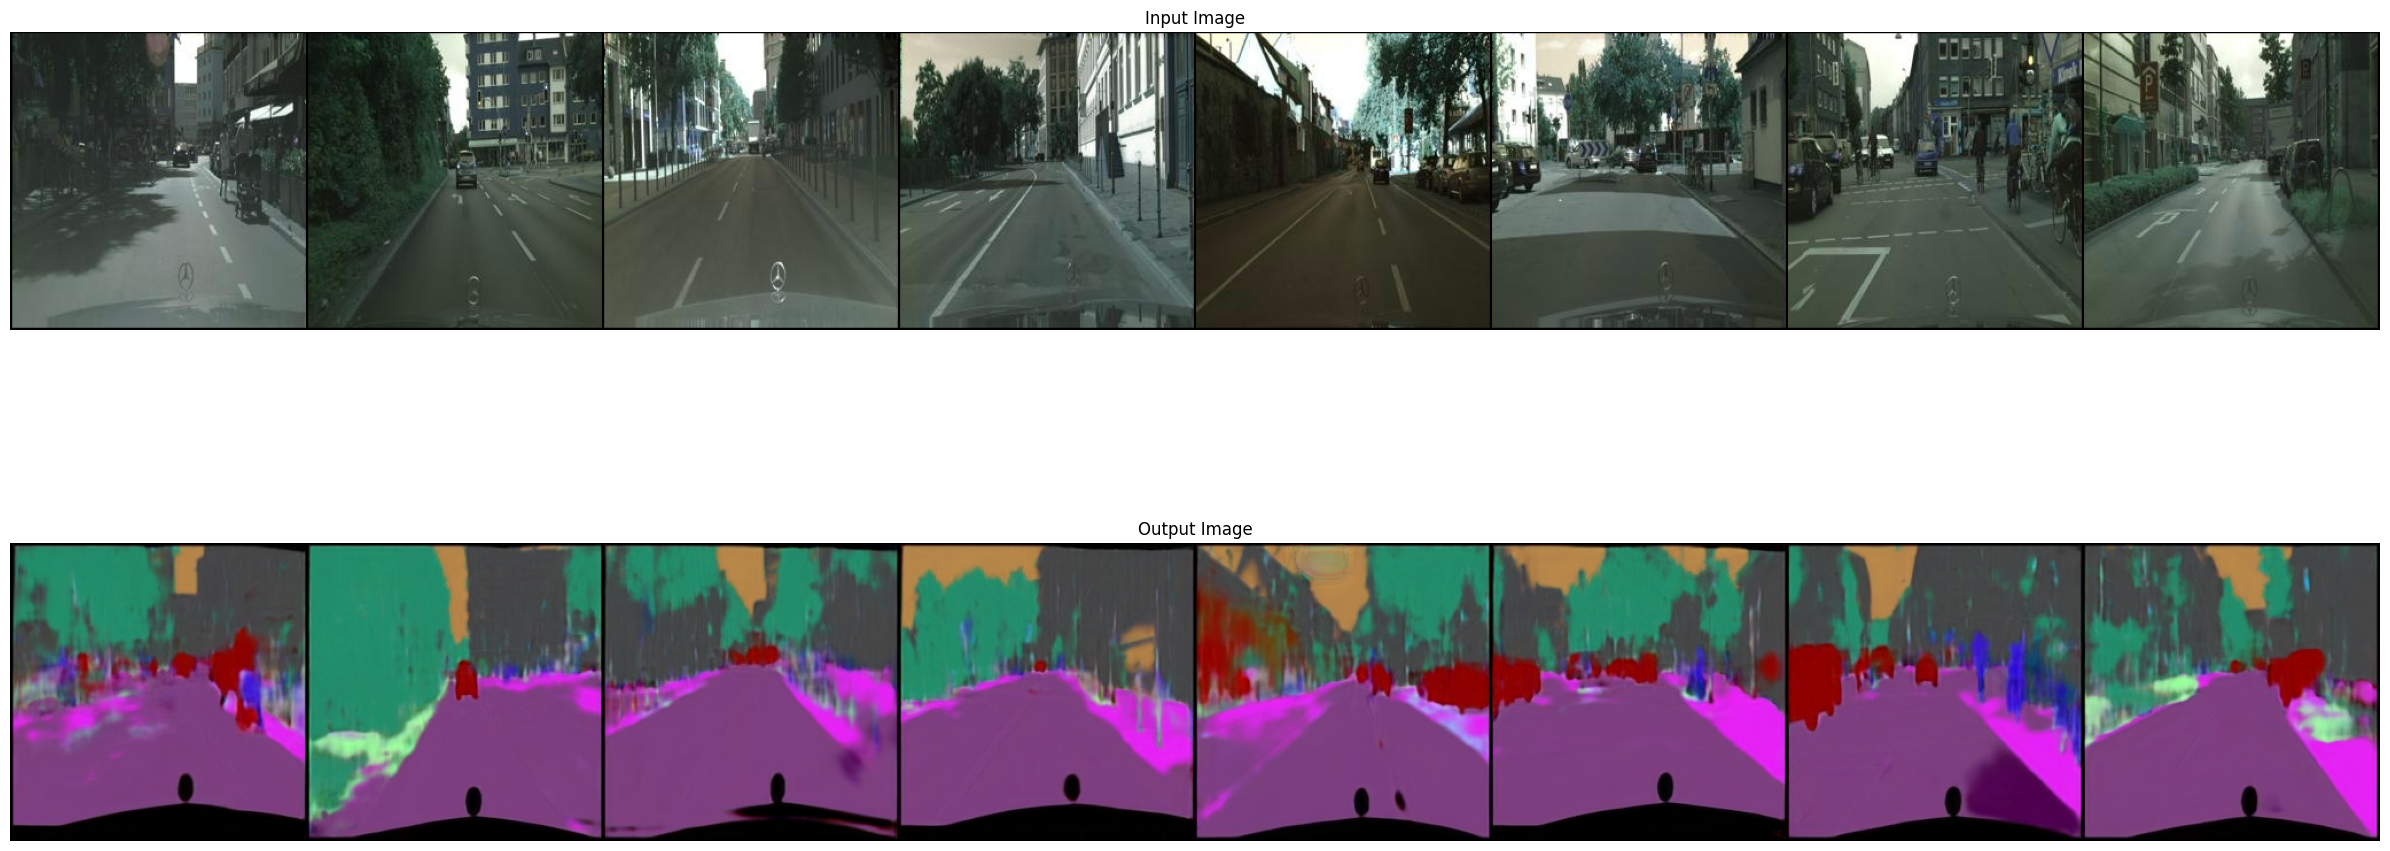

In [36]:
import matplotlib.pyplot as plt

# Load the saved input and output images
input_img = plt.imread('sample_input.png')
output_img = plt.imread('sample_output.png')

# Create a figure with subplots
fig, axs = plt.subplots(2,1, figsize=(12*2, 6*2))

# Display the input image in the first subplot
axs[0].imshow(input_img)
axs[0].axis('off')  # Hide the axes
axs[0].set_title('Input Image')

# Display the output image in the second subplot
axs[1].imshow(output_img)
axs[1].axis('off')  # Hide the axes
axs[1].set_title('Output Image')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
#Cargar el modelo entrenado y seguir haciendo pruebas
#'/content/drive/MyDrive/TEC/Research/Semantic Segmentation/unet_cityscapes.pth'

# **Visualización de Feature maps**

In [38]:
print(model)

Attention_UNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True

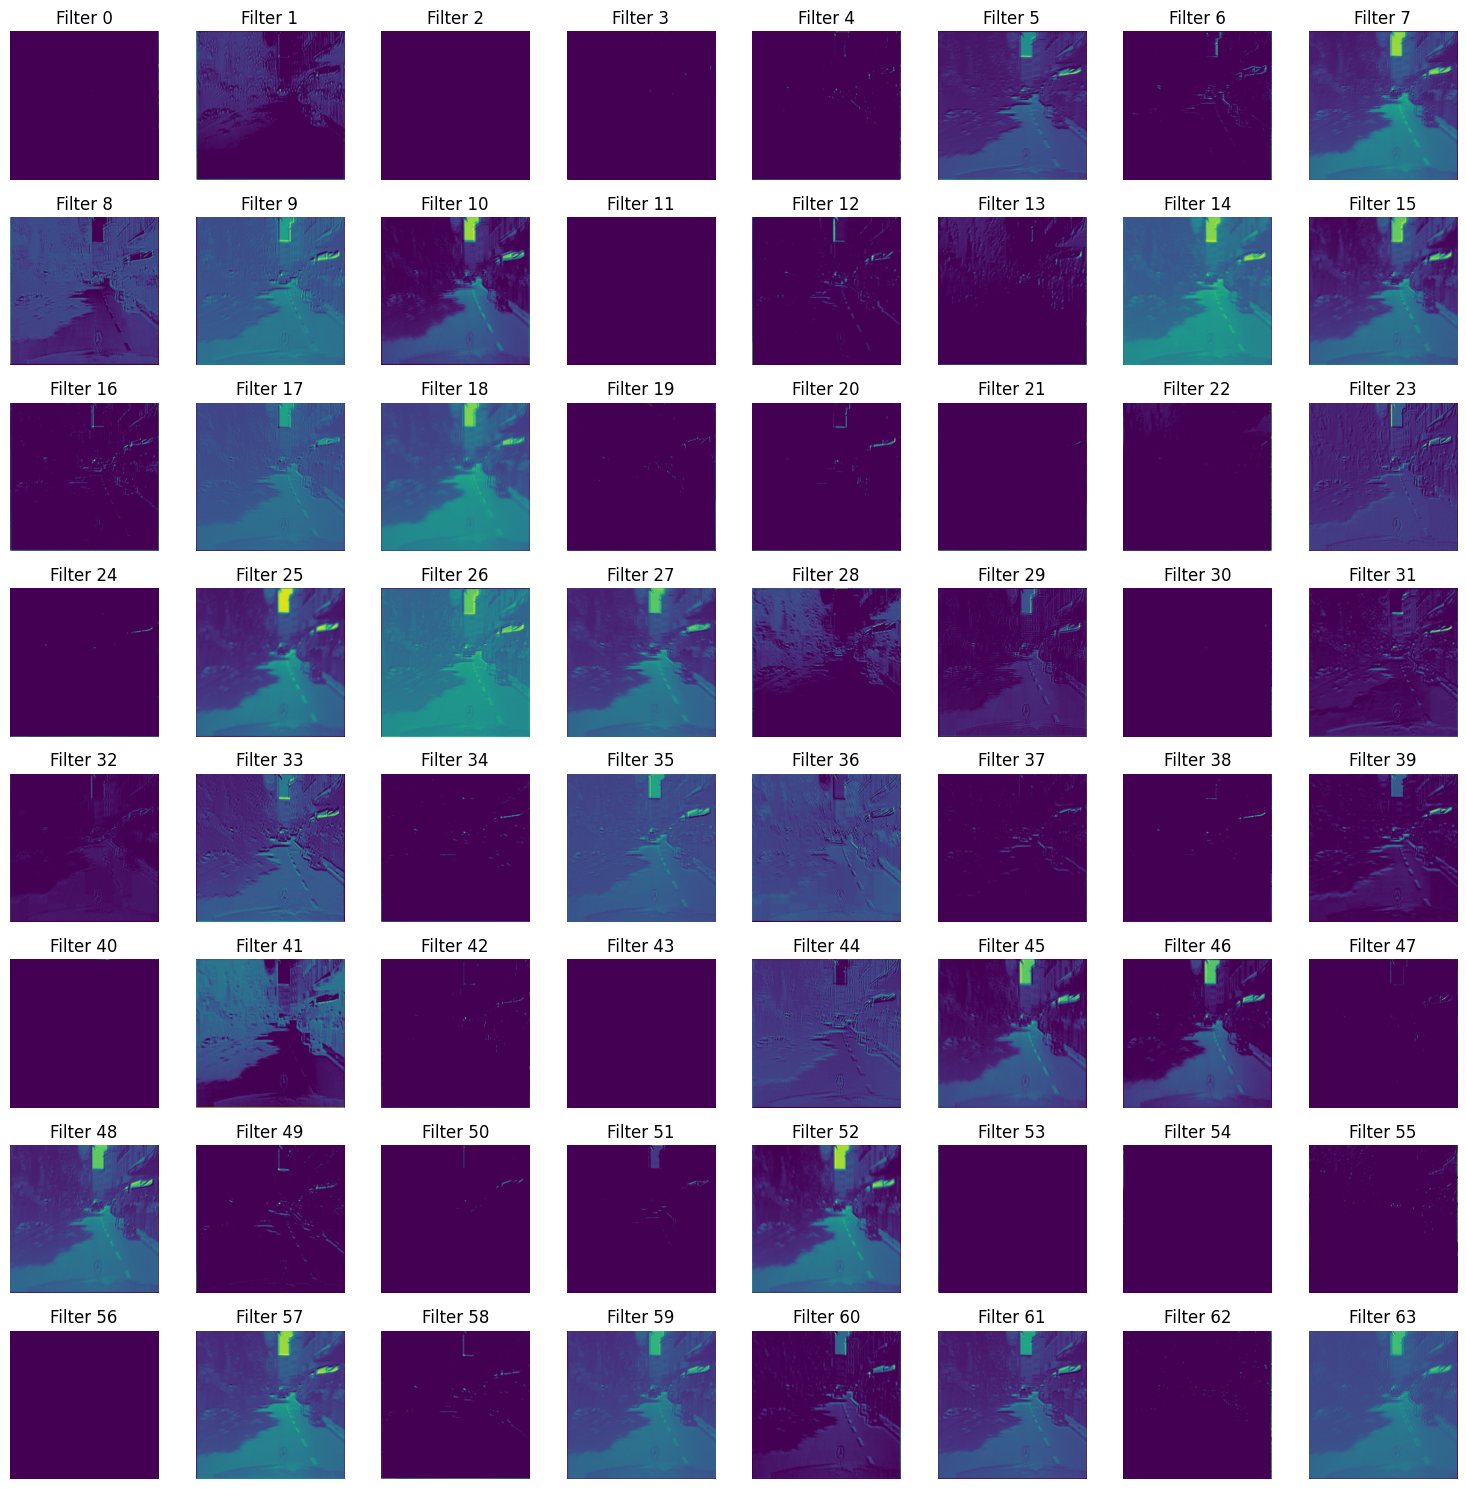

In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_feature_maps(model, image, layer_idx=0):
    """
    Visualizes feature maps of a given layer in the model.
    :param model: Trained PyTorch model
    :param image: Input image tensor [C, H, W]
    :param layer_idx: Index of the layer to visualize
    """
    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    activation = None
    def hook_fn(module, input, output):
        nonlocal activation
        activation = output

    # Get the target layer
    layer = list(model.children())[layer_idx]
    hook = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(image)

    hook.remove()

    if activation is None:
        print("Error: No activation captured.")
        return

    activation = activation.squeeze(0).cpu().numpy()  # Remove batch dim
    num_filters = activation.shape[0]
    cols = 8  # Define number of columns for the plot
    rows = np.ceil(num_filters / cols).astype(int)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i in range(num_filters):
        ax = axes[i // cols, i % cols]
        ax.imshow(activation[i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i}')

    plt.tight_layout()
    plt.show()

# Example usage
sample_image, _, _ = next(iter(val_loader))  # Get a sample image from validation set
sample_image = sample_image[0]  # Take the first image from the batch
visualize_feature_maps(attention_unet, sample_image, layer_idx=1)


# **Ejemplo**

In [40]:
model.att2

AttentionBlock(
  (w_g): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (w_x): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (psi): Sequential(
    (0): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
  )
  (relu): ReLU(inplace=True)
)

In [46]:
layer_before = model.att2.w_x[1]
layer_after = model.att2.relu

In [47]:
#layer = model.up2.up[3]
#layer

In [48]:
def visualize_feature_maps(model, image, layer):
    """
    Visualizes feature maps of a given layer in the model.
    :param model: Trained PyTorch model
    :param image: Input image tensor [C, H, W]
    :param layer: Specific layer to visualize
    """
    model.eval()
    #image = image.unsqueeze(0).to(device)  # Add batch dimension
    image = image.to(device)  # Add batch dimension

    activation = None
    def hook_fn(module, input, output):
        nonlocal activation
        activation = output

    # Register hook to the specific layer
    hook = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(image)

    hook.remove()

    if activation is None:
        print("Error: No activation captured.")
        return

    activation = activation.squeeze(0).cpu().numpy()  # Remove batch dim
    num_filters = activation.shape[0]
    cols = 8  # Define number of columns for the plot
    rows = np.ceil(num_filters / cols).astype(int)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i in range(num_filters):
        ax = axes[i // cols, i % cols]
        ax.imshow(activation[i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i}')

    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Mascara Image')

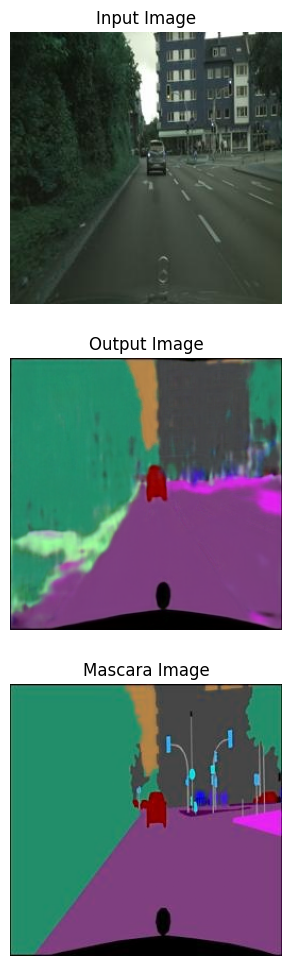

In [49]:
save_image(images[1], 'Entrada.png')
Entrada = plt.imread('Entrada.png')

save_image(outputs[1], 'Salida.png')
Salida = plt.imread('Salida.png')

save_image(masks[1], 'Mascara.png')
Mascara = plt.imread('Mascara.png')

fig, axs = plt.subplots(3,1, figsize=(12*2, 6*2))

axs[0].imshow(Entrada)
axs[0].axis('off')  # Hide the axes
axs[0].set_title('Input Image')

# Display the output image in the second subplot
axs[1].imshow(Salida)
axs[1].axis('off')  # Hide the axes
axs[1].set_title('Output Image')

# Display the output image in the second subplot
axs[2].imshow(Mascara)
axs[2].axis('off')  # Hide the axes
axs[2].set_title('Mascara Image')

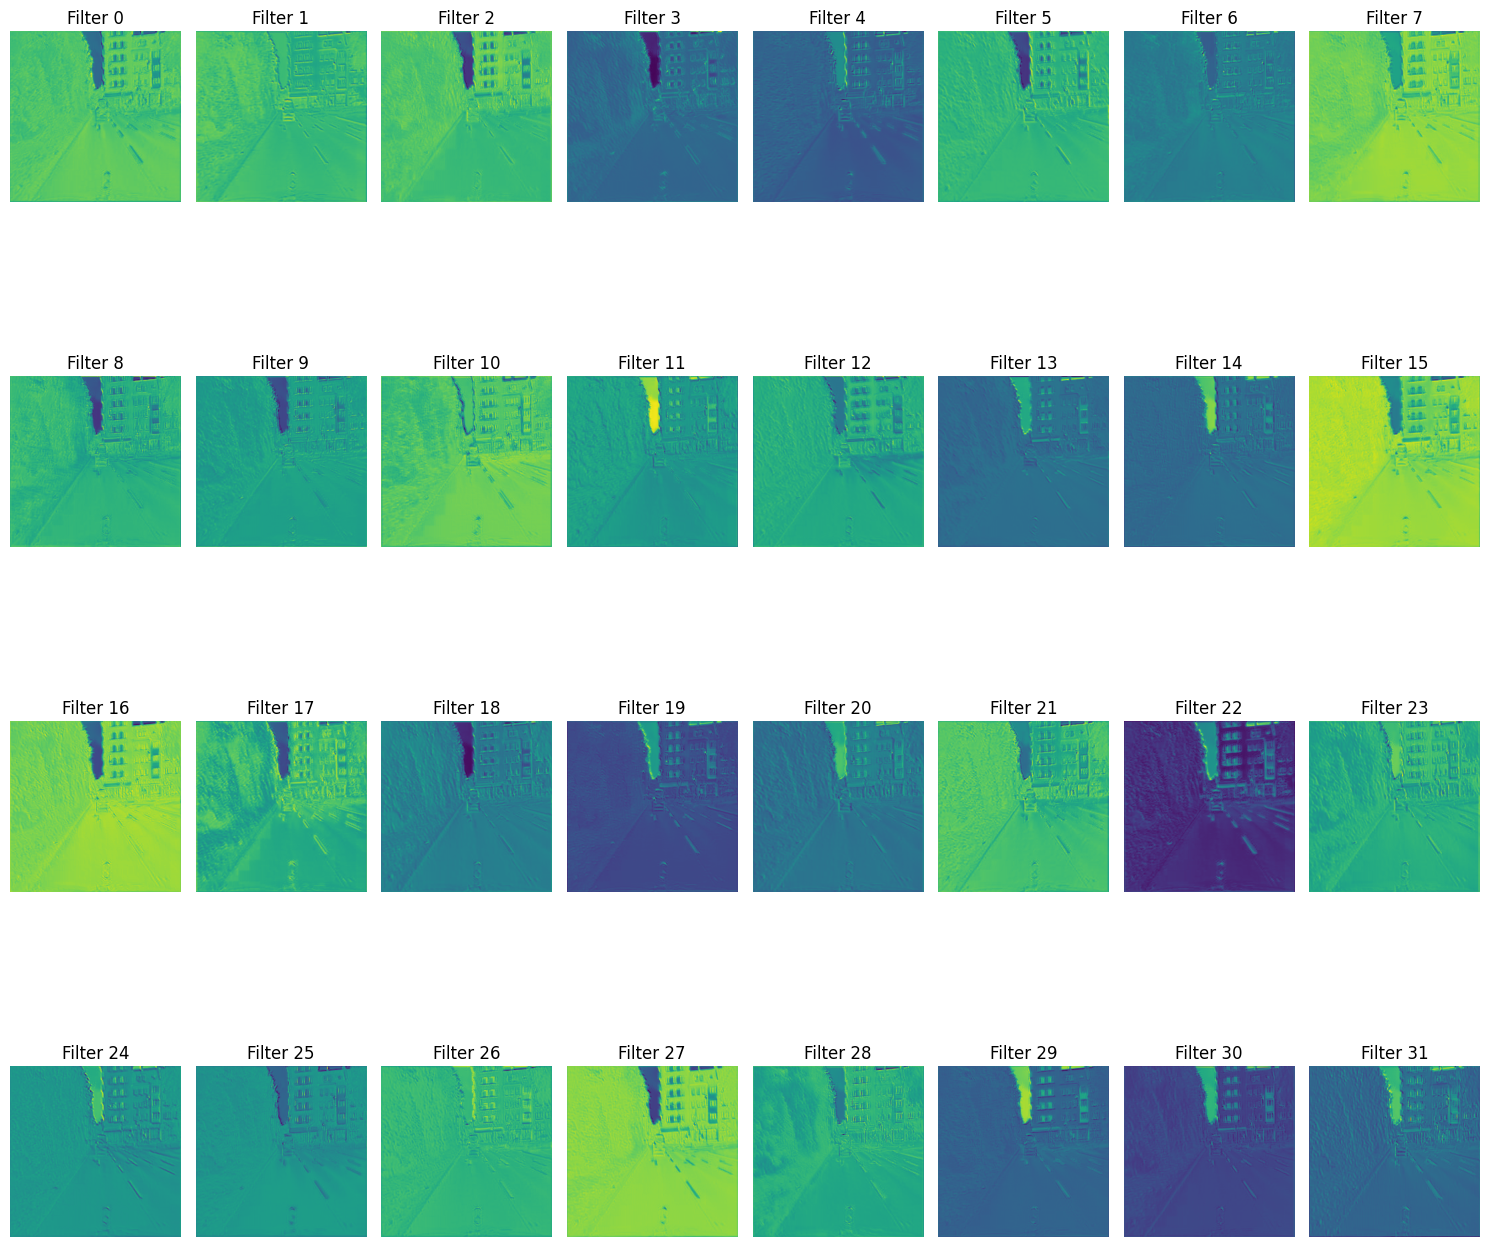

In [50]:
# Convert Entrada from NumPy array to PyTorch tensor
Entrada_tensor = torch.from_numpy(Entrada).permute(2, 0, 1).unsqueeze(0).float()

# Pass the PyTorch tensor to the function
visualize_feature_maps(model, Entrada_tensor, layer_before)

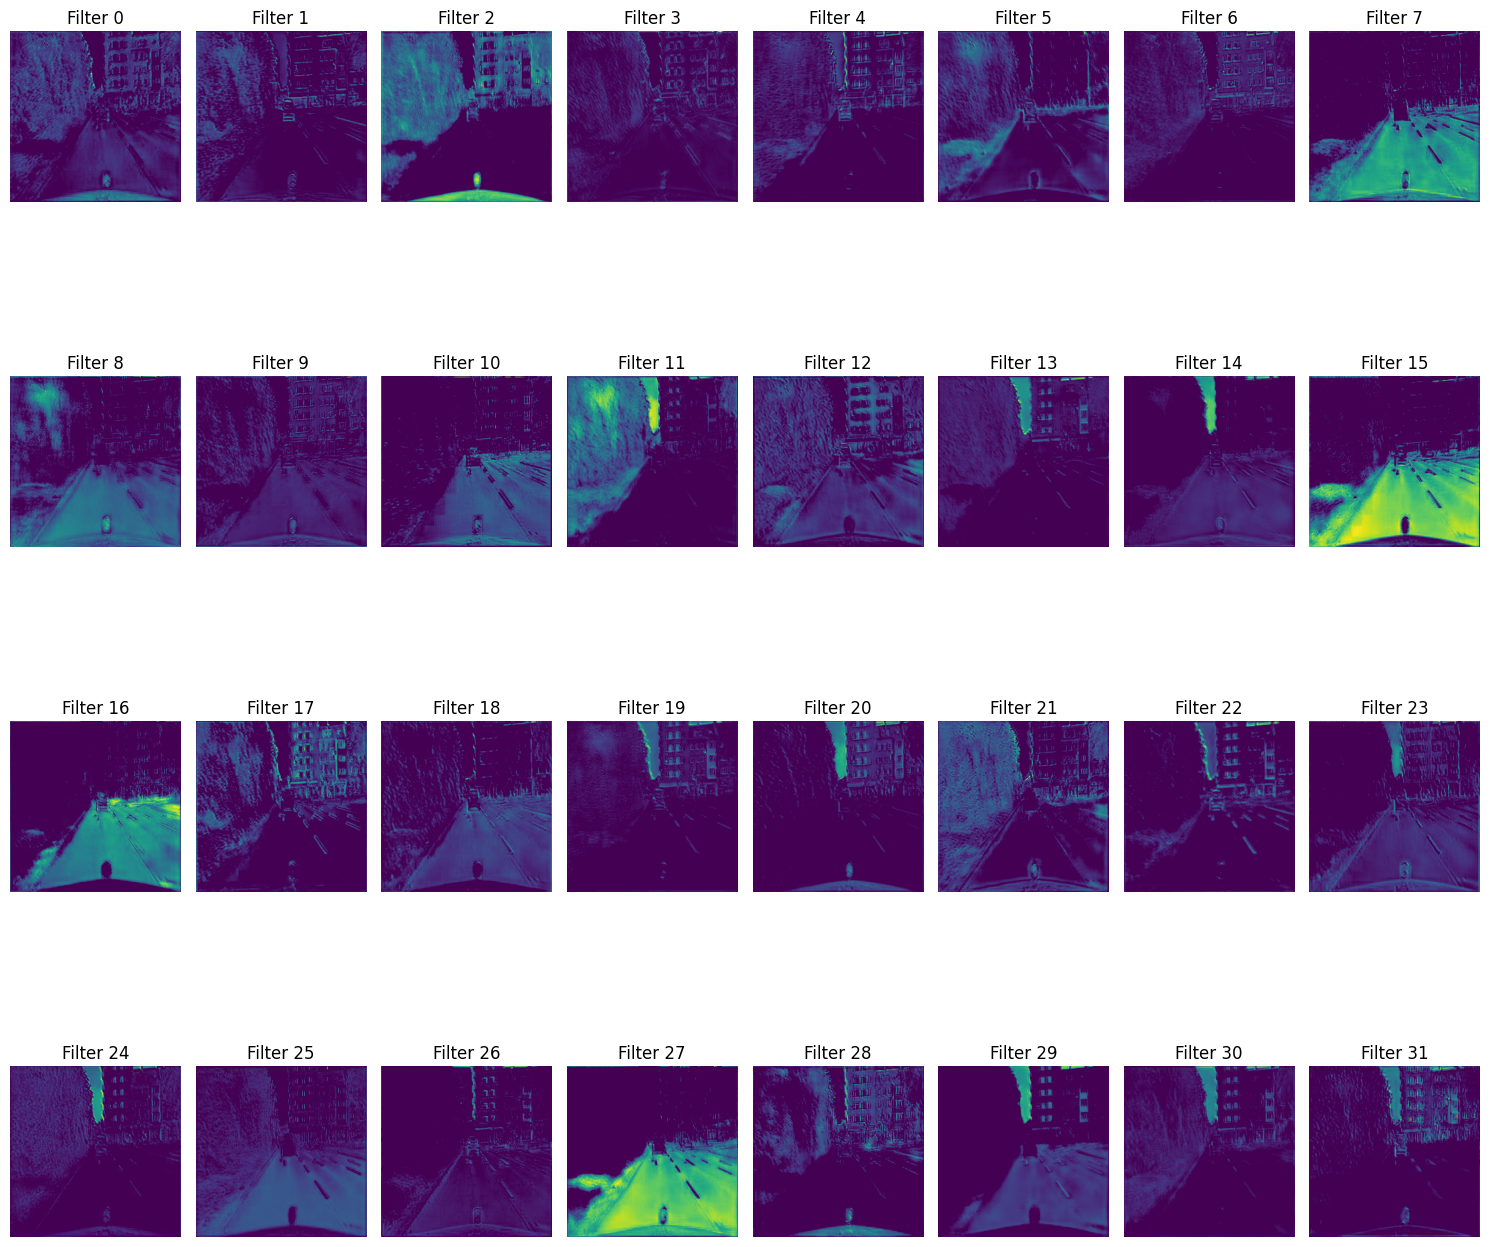

In [45]:
# Convert Entrada from NumPy array to PyTorch tensor
Entrada_tensor = torch.from_numpy(Entrada).permute(2, 0, 1).unsqueeze(0).float()

# Pass the PyTorch tensor to the function
visualize_feature_maps(model, Entrada_tensor, layer_after)